In [87]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0
torchvision version: 0.16.0


In [141]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [91]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [93]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [95]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

In [98]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [100]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26326accbd0>,
 ['pizza', 'steak', 'sushi'])

In [102]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

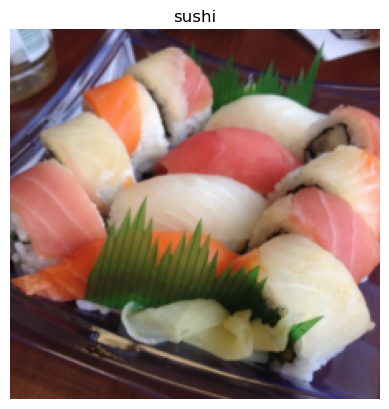

In [103]:
# Plot image with matplotlib
%matplotlib inline
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);
plt.show()

In [106]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor.shape

torch.Size([1, 3, 224, 224])

In [108]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [110]:
patcher = nn.Conv2d(in_channels=3,out_channels=768,kernel_size=16,stride=16,padding=0)
patcher(rand_image_tensor).shape

torch.Size([1, 768, 14, 14])

In [112]:
flatten = nn.Flatten(start_dim=2,end_dim=3)
flatten(patcher(rand_image_tensor)).shape

torch.Size([1, 768, 196])

In [114]:
patch_embedding = PatchEmbedding()
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape : {rand_image_tensor.shape}")
print(f"Output shape : {patch_embedding_output.shape}")

Input shape : torch.Size([1, 3, 224, 224])
Output shape : torch.Size([1, 196, 768])


In [116]:
transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [118]:
from torchinfo import summary

summary(model = transformer_encoder_layer,input_size = patch_embedding_output.shape,depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [1, 196, 768]             7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.60
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.60

In [120]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer = transformer_encoder_layer,
    num_layers = 12
)

C:\Users\golam\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [122]:
summary(model = transformer_encoder,input_size = patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [1, 196, 768]             --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [1, 196, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-2      [1, 196, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-3      [1, 196, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-4      [1, 196, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-5      [1, 196, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-6      [1, 196, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-7      [1, 196, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-8      [1, 196, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-9      [1, 196, 768]             7,087,872
│    └─TransformerEncoderLayer: 2-10     [1, 196, 768]             7,087,872
│    └─Transfor

In [124]:
class ViT(nn.Module): 
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1, 
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size 
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout 
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

In [126]:
#understanding how expand function works 
exp = nn.Parameter(torch.randn(1,1,5))
exp

Parameter containing:
tensor([[[-1.3074,  2.0094,  1.3115,  0.2248, -0.4360]]], requires_grad=True)

In [128]:
print(exp.expand(5,-1,-1).shape)
exp.expand(5,-1,-1)

torch.Size([5, 1, 5])


tensor([[[-1.3074,  2.0094,  1.3115,  0.2248, -0.4360]],

        [[-1.3074,  2.0094,  1.3115,  0.2248, -0.4360]],

        [[-1.3074,  2.0094,  1.3115,  0.2248, -0.4360]],

        [[-1.3074,  2.0094,  1.3115,  0.2248, -0.4360]],

        [[-1.3074,  2.0094,  1.3115,  0.2248, -0.4360]]],
       grad_fn=<ExpandBackward0>)

In [130]:
# understanding the shape of x = positional embedding + x
x = torch.randn(32,197,768)
# print(x)
pos_emb = torch.randn(1,197,768)
# print(pos_emb)
x = pos_emb+x
# print(x)
x.shape

torch.Size([32, 197, 768])

In [132]:
#understanding the shape of transformers output
x = torch.randn(32,197,768)
transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=768,
                                                                                              nhead=12,
                                                                                              dim_feedforward=3072,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=12)
y=transformer_encoder(x)

In [133]:
y.shape,y[:,0].shape

(torch.Size([32, 197, 768]), torch.Size([32, 768]))

In [134]:
nn.Parameter(torch.randn(1, 1, 768), requires_grad=True).shape

torch.Size([1, 1, 768])

In [135]:
demo_img = torch.randn(1,3,224,224)
print(demo_img.shape)
vit = ViT(num_classes=len(class_names))
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[-0.1833,  1.0968,  0.4983]], grad_fn=<AddmmBackward0>)

In [136]:
embedding_dim = 768
class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                       requires_grad=True)
class_token

Parameter containing:
tensor([[[ 1.3541e+00, -9.7383e-01, -4.7922e-01,  8.4004e-01, -5.5641e-01,
           1.1078e+00, -1.4671e+00,  3.6960e-01, -2.3203e-01, -1.6446e-01,
           8.3872e-01, -6.5670e-01, -3.0833e-01, -1.3717e+00, -8.7774e-01,
           1.0929e+00, -2.3333e-01, -1.2339e+00, -6.1057e-01,  3.0375e-01,
          -5.6276e-02, -1.0625e+00, -1.8904e-01,  6.7042e-03, -1.5131e-01,
           1.1592e+00,  1.4005e+00,  8.3494e-02,  8.5424e-01,  6.9236e-02,
          -5.5442e-02, -8.5069e-01,  1.8789e+00,  6.1303e-01,  2.4757e-01,
           1.3641e-01, -5.8468e-01,  9.9203e-01, -8.5302e-01, -7.0140e-01,
          -6.2841e-01,  2.3733e+00,  1.7757e+00,  1.3317e+00,  6.8906e-01,
           2.2449e-01,  2.2046e-01, -1.8064e+00,  2.3247e-01,  1.2260e+00,
          -2.4650e+00,  1.3808e+00, -8.7309e-01,  1.0721e+00,  1.5254e+00,
          -7.1119e-01, -1.9263e-01, -6.2682e-01,  1.7240e+00, -1.0914e+00,
           1.2467e+00, -2.3517e-01, -4.3942e-01,  1.3244e+00,  3.2139e-01,
   

In [137]:
patch_size = 16
img_size = 224
num_patches = (img_size* img_size) // patch_size**2
positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
positional_embedding.shape

torch.Size([1, 197, 768])

In [138]:
batch_size = 32
print(class_token.shape)
class_token.expand(batch_size, -1,-1).shape

torch.Size([1, 1, 768])


torch.Size([32, 1, 768])

In [83]:
import torchvision 

vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights = vit_weights)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [77]:
from helper_functions import plot_loss_curves

In [147]:
for param in pretrained_vit.parameters():
    param.requires_grad = False

embedding_dim = 768
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim, out_features=len(class_names))
)
summary(model=vit,
       input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [149]:
# Print a summary
summary(model=pretrained_vit, 
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [151]:
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
vit_transforms = vit_weights.transforms() # get transforms from vit_weights
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, 
                                                                                           test_dir=test_dir, # use 10% data for testing
                                                                                           transform=vit_transforms, 
                                                                                           batch_size=32)

[INFO] Did not find data\pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...
